# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

### Загружаем и смотрим данные 

In [7]:
df = pd.read_excel('../data/geo.xlsx', index_col=0)

In [8]:
df

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1
...,...,...,...
108801,37.454528,55.792331,-1
108802,37.384325,55.899068,-1
108803,37.421066,55.848756,1
108804,37.448509,55.793065,-1


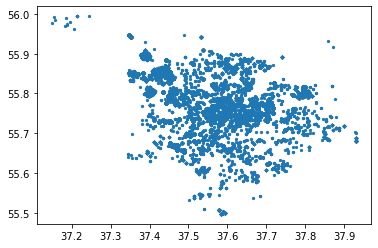

In [10]:
plt.scatter(df.x, df.y, s=5)

По картинке сложно что-либо сказать об интуитивном количестве кластеров в данном примере

In [11]:
coordinates = df[['x', 'y']]

### Масштабируем данные

In [12]:
scaler = StandardScaler()
scaler.fit(coordinates)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
print(scaler.mean_)

[37.5675316  55.76634559]


In [14]:
coordinates_norm = scaler.transform(coordinates)

In [15]:
coordinates_norm

array([[ 0.36791896,  0.15955291],
       [ 0.36791896,  0.15955291],
       [ 0.2931784 , -0.34813064],
       ...,
       [-1.20058354,  1.1836816 ],
       [-0.97563233,  0.38377766],
       [-0.95317246,  1.00936916]])

### Подбираем K

In [16]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(coordinates_norm, )
    k_inertia.append(clf_kmeans.inertia_)

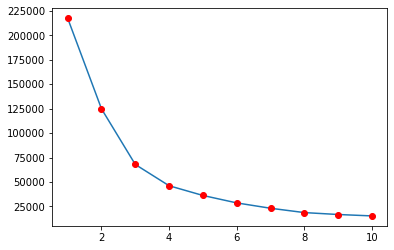

In [17]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

In [18]:
diff = np.diff(k_inertia)

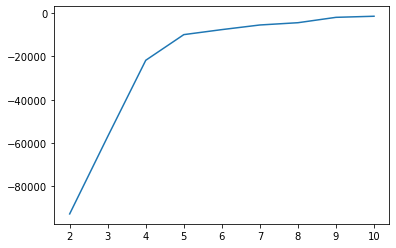

In [19]:
plt.plot(ks[1:], diff)

Точки, подозрительные на количество кластеров - 4 и 5

### Строим разделение на 4 и 5 кластеров и оцениваем результат

2it [07:17, 218.82s/it]


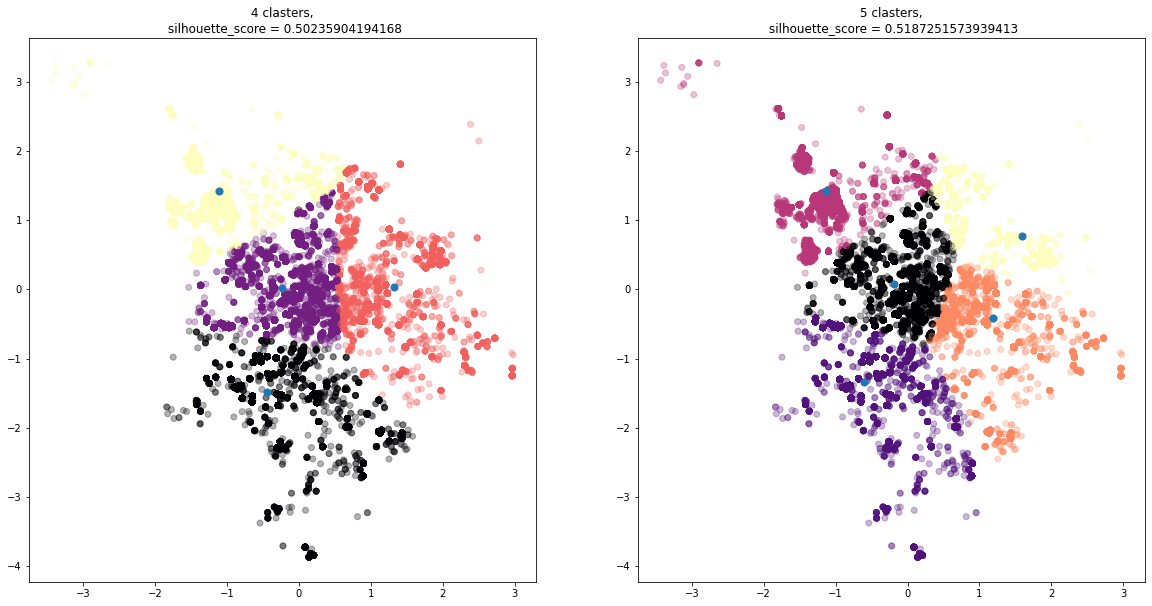

In [20]:
n_clusters = [4, 5]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
alpha = 0.3

for ax, n in tqdm(zip(axes, n_clusters)):
    algorithm = KMeans(n, n_jobs=-1)
    clusters = algorithm.fit_predict(coordinates_norm)
    ax.scatter(coordinates_norm[:, 0], coordinates_norm[:, 1], c=clusters, cmap='magma', alpha=alpha)
    ax.set_title('{} clasters,\n silhouette_score = {}'
                 .format(n, silhouette_score(coordinates_norm, clusters)))
    centers = algorithm.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50)

Похоже, что и визуально и по метрике случай с 5 кластерами выглядит чуть получше

### Делим датасет на "положительный" и "отрицательный"

#### Положительный

In [21]:
pos = df[df.comment_class==1]

In [22]:
scaler = StandardScaler()
scaler.fit(pos)
pos_norm = pd.DataFrame(scaler.transform(pos), columns=['x', 'y', 'comment_class'])

In [23]:
pos_norm

,x,y,comment_class
0,-0.167012,-0.666835,0.0
1,-0.164051,-0.791167,0.0
2,-0.394750,-0.880114,0.0
3,-0.335511,-0.831149,0.0
4,-0.164051,-0.791167,0.0
...,...,...,...
13654,-1.424854,1.055231,0.0
13655,-1.351145,1.096229,0.0
13656,-1.198668,0.859500,0.0
13657,-1.174095,0.145201,0.0


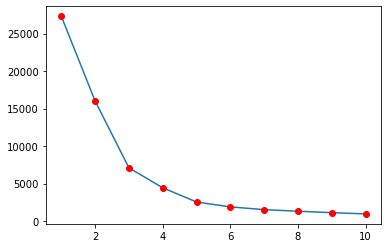

In [24]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(pos_norm, )
    k_inertia.append(clf_kmeans.inertia_)
    
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

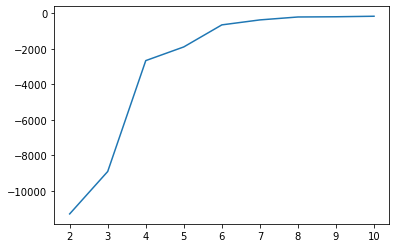

In [25]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

точки 4, 5 и 6 подозрительны на количество кластеров

3it [00:11,  3.77s/it]


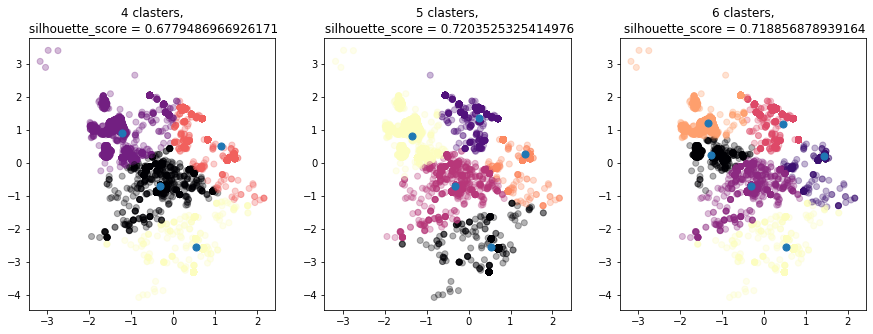

In [26]:
n_clusters = [4, 5, 6]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
alpha = 0.3

for ax, n in tqdm(zip(axes, n_clusters)):
    algorithm = KMeans(n, n_jobs=-1)
    clusters = algorithm.fit_predict(pos_norm[['x', 'y']])
    ax.scatter(pos_norm.x,pos_norm.y, c=clusters, cmap='magma', alpha=alpha)
    ax.set_title('{} clasters,\n silhouette_score = {}'
                 .format(n,  
                         silhouette_score(pos_norm[['x', 'y']], clusters)))
    centers = algorithm.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50)

Вариант с 5 кластерами выглядит чуть получше

#### Отрицательный

In [27]:
neg = df[df.comment_class==-1]

In [28]:
scaler = StandardScaler()
scaler.fit(neg)
neg_norm = pd.DataFrame(scaler.transform(neg), columns=['x', 'y', 'comment_class'])

In [29]:
neg_norm

,x,y,comment_class
0,0.430030,0.192659,0.0
1,0.430030,0.192659,0.0
2,0.353378,-0.310039,0.0
3,-0.023003,-0.499906,0.0
4,0.043451,-0.456727,0.0
...,...,...,...
95142,-0.754699,-1.359098,0.0
95143,-0.897276,0.404243,0.0
95144,-1.487446,1.922280,0.0
95145,-0.947875,0.414682,0.0


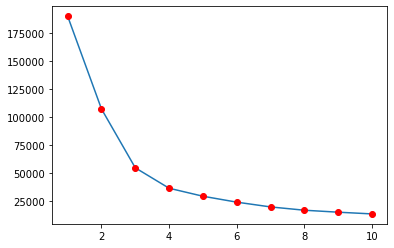

In [30]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(neg_norm, )
    k_inertia.append(clf_kmeans.inertia_)
    
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

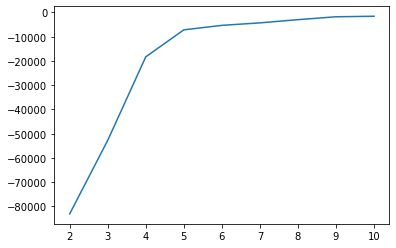

In [31]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

Точки 4 и 5 подозрительны на количество кластеров

2it [05:39, 169.65s/it]


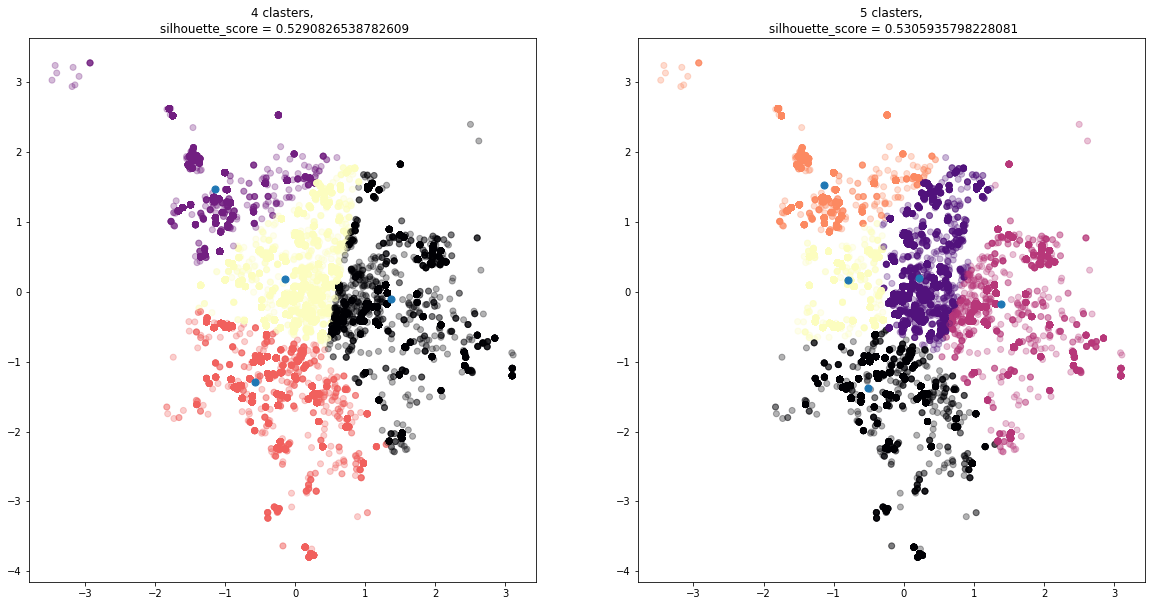

In [32]:
n_clusters = [4, 5]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
alpha = 0.3

for ax, n in tqdm(zip(axes, n_clusters)):
    algorithm = KMeans(n, n_jobs=-1)
    clusters = algorithm.fit_predict(neg_norm[['x', 'y']])
    ax.scatter(neg_norm.x,neg_norm.y, c=clusters, cmap='magma', alpha=alpha)
    ax.set_title('{} clasters,\n silhouette_score = {}'
                 .format(n,  
                         silhouette_score(neg_norm[['x', 'y']], clusters)))
    centers = algorithm.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50)

Похоже и здесь вариант с 5 кластерами выглядит чуть получше